## Import

In [ ]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch .nn as nn

seed = 1
torch.manual_seed(seed)

## Download

In [ ]:
# https://drive.google.com/file/d/178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
!gdown --id 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
To: /content/dataset.zip
100% 2.35M/2.35M [00:00<00:00, 159MB/s]


In [ ]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
   creating: dataset/
  inflating: dataset/weatherHistory.csv  


In [43]:
dataset_filepath = 'dataset/weatherHistory.csv'
df = pd. read_csv(dataset_filepath)

In [44]:
univariate_df = df['Temperature (C)']
univariate_df . index = df['Formatted Date']

In [45]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx: feature_end_idx]
        label = df[label_start_idx:(idx + window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

## Chia bộ dữ liệu train, val, test

In [46]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

## Pytorch datasets

In [47]:
class WeatherForecast (Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y


## Dataloader

In [48]:
train_dataset = WeatherForecast(
    X_train, y_train
)
val_dataset = WeatherForecast(
    X_val, y_val
)
test_dataset = WeatherForecast(
    X_test, y_test
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [49]:
class WeatherForecastor (nn.Module):
    def __init__(
        self, embedding_dim, hidden_size,
        n_layers, dropout_prob
    ):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [50]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)

In [51]:
lr = 1e-3
epochs = 50

criterion = nn. MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [52]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}: \t Train loss : {train_loss:.4f} \t Val loss : {val_loss:.4f}')

    return train_losses, val_losses

In [53]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [54]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1: 	 Train loss : 123.8848 	 Val loss : 42.1025
EPOCH 2: 	 Train loss : 30.2538 	 Val loss : 7.4225
EPOCH 3: 	 Train loss : 15.3600 	 Val loss : 3.6578
EPOCH 4: 	 Train loss : 12.4656 	 Val loss : 2.3114
EPOCH 5: 	 Train loss : 10.9223 	 Val loss : 1.9912
EPOCH 6: 	 Train loss : 10.0683 	 Val loss : 1.8635
EPOCH 7: 	 Train loss : 9.7295 	 Val loss : 1.7566
EPOCH 8: 	 Train loss : 9.2122 	 Val loss : 2.3727
EPOCH 9: 	 Train loss : 9.1326 	 Val loss : 1.7095
EPOCH 10: 	 Train loss : 8.8962 	 Val loss : 2.0364
EPOCH 11: 	 Train loss : 8.8199 	 Val loss : 1.6306
EPOCH 12: 	 Train loss : 8.4911 	 Val loss : 1.7220
EPOCH 13: 	 Train loss : 8.3573 	 Val loss : 1.5836
EPOCH 14: 	 Train loss : 8.1709 	 Val loss : 1.7442
EPOCH 15: 	 Train loss : 7.9302 	 Val loss : 1.8325
EPOCH 16: 	 Train loss : 7.5436 	 Val loss : 1.5095
EPOCH 17: 	 Train loss : 7.5145 	 Val loss : 1.7165
EPOCH 18: 	 Train loss : 7.3646 	 Val loss : 1.9075
EPOCH 19: 	 Train loss : 7.3244 	 Val loss : 1.6282
EPOCH 20: 	 T

In [55]:
torch.save(model.state_dict(), 'Hour_Temp_Forecasting_LSTM.pth')

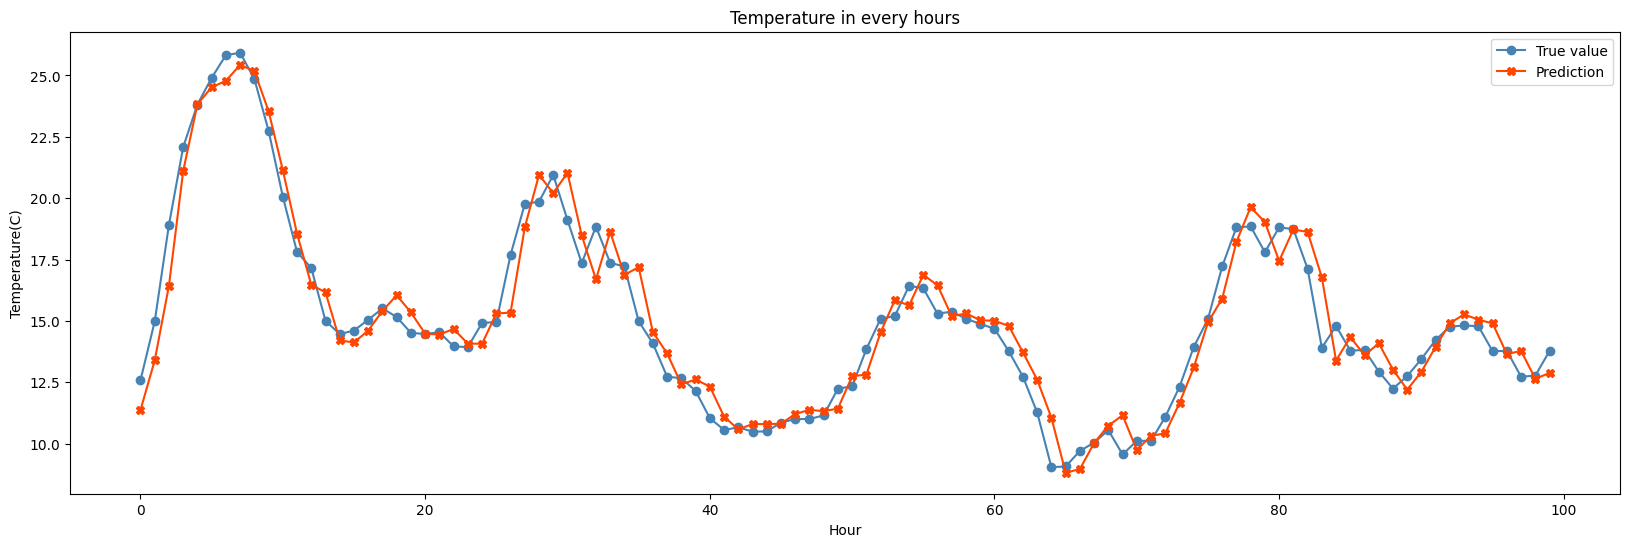

In [56]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y. flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature(C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
  outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)


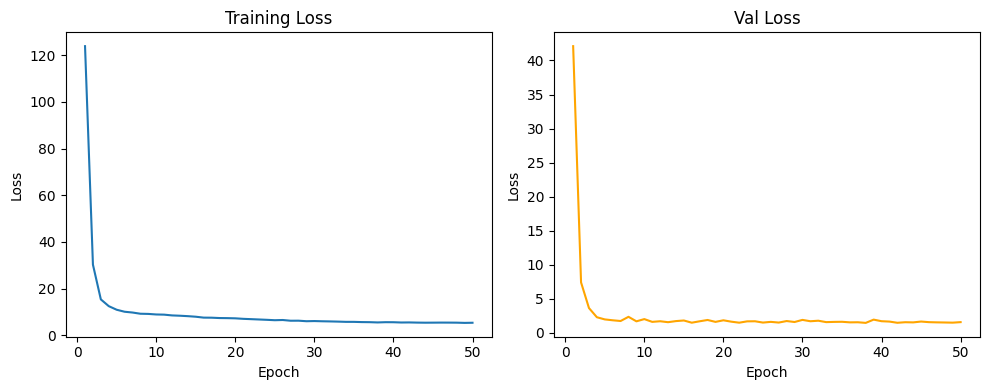

In [57]:
epochs_range = range(1, epochs + 1)

# Plotting Training and Validation Loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Training Loss
axes[0].plot(epochs_range, train_losses, color='tab:blue')
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Validation Loss
axes[1].plot(epochs_range, val_losses, color='orange')
axes[1].set_title("Val Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

In [58]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val / test dataset ')
print('Val accuracy : ', val_acc)
print('Test accuracy : ', test_acc)

Evaluation on val / test dataset 
Val accuracy :  0.005391394504924832
Test accuracy :  0.006639692914202718
